# 网络中的网络（NiN）
:label:`sec_nin`

LeNet、AlexNet和VGG都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取空间结构特征；然后通过全连接层对特征的表征进行处理。
AlexNet和VGG对LeNet的改进主要在于如何扩大和加深这两个模块。
或者，可以想象在这个过程的早期使用全连接层。然而，如果使用了全连接层，可能会完全放弃表征的空间结构。
*网络中的网络*（*NiN*）提供了一个非常简单的解决方案：在每个像素的通道上分别使用多层感知机 :cite:`Lin.Chen.Yan.2013`

## (**NiN块**)

回想一下，卷积层的输入和输出由四维张量组成，张量的每个轴分别对应样本、通道、高度和宽度。
另外，全连接层的输入和输出通常是分别对应于样本和特征的二维张量。
NiN的想法是在每个像素位置（针对每个高度和宽度）应用一个全连接层。
如果我们将权重连接到每个空间位置，我们可以将其视为$1\times 1$卷积层（如 :numref:`sec_channels`中所述），或作为在每个像素位置上独立作用的全连接层。
从另一个角度看，即将空间维度中的每个像素视为单个样本，将通道维度视为不同特征（feature）。

 :numref:`fig_nin`说明了VGG和NiN及它们的块之间主要架构差异。
NiN块以一个普通卷积层开始，后面是两个$1 \times 1$的卷积层。这两个$1 \times 1$卷积层充当带有ReLU激活函数的逐像素全连接层。
第一层的卷积窗口形状通常由用户设置。
随后的卷积窗口形状固定为$1 \times 1$。

![对比 VGG 和 NiN 及它们的块之间主要架构差异。](../img/nin.svg)
:width:`600px`
:label:`fig_nin`


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

# 定义了一个名为 nin_block 的函数，它接收输入通道数（in_channels）、输出通道数（out_channels）、卷积核大小（kernel_size）、步幅（strides）和填充（padding）作为参数。
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    # 返回一个 Sequential 容器，该容器按照顺序组合了多个层。
    return nn.Sequential(
        # 使用 nn.Conv2d 创建一个卷积层，指定输入通道数、输出通道数、卷积核大小、步幅和填充。
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        # 使用 nn.ReLU 创建一个 ReLU 激活函数层，用于引入非线性性质。
        nn.ReLU(),
        # 再次使用 nn.Conv2d 创建一个卷积层，输入和输出通道数都是 out_channels，卷积核大小为 1x1，用于引入非线性性质。
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

## [**NiN模型**]

最初的NiN网络是在AlexNet后不久提出的，显然从中得到了一些启示。
NiN使用窗口形状为$11\times 11$、$5\times 5$和$3\times 3$的卷积层，输出通道数量与AlexNet中的相同。
每个NiN块后有一个最大汇聚层，汇聚窗口形状为$3\times 3$，步幅为2。

NiN和AlexNet之间的一个显著区别是NiN完全取消了全连接层。
相反，NiN使用一个NiN块，其输出通道数等于标签类别的数量。最后放一个*全局平均汇聚层*（global average pooling layer），生成一个对数几率	（logits）。NiN设计的一个优点是，它显著减少了模型所需参数的数量。然而，在实践中，这种设计有时会增加训练模型的时间。


In [3]:
# 创建一个nn.Sequential的实例，用于将各个层按顺序组合成一个神经网络模型。
net = nn.Sequential(
    # 调用nin_block函数创建一个NIN块。
    # 该块接受输入通道数为1，输出通道数为96，卷积核大小为11x11，步幅为4，填充为0。这个块会应用一系列的卷积操作，并使用ReLU作为激活函数。
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    # 添加一个最大池化层，池化窗口大小为3x3，步幅为2。该层将特征图的尺寸缩小一半。
    nn.MaxPool2d(3, stride=2),
    # 再次调用nin_block函数创建一个NIN块。该块接受输入通道数为96，输出通道数为256，卷积核大小为5x5，步幅为1，填充为2。
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    # 再次添加一个最大池化层，池化窗口大小为3x3，步幅为2。
    nn.MaxPool2d(3, stride=2),
    # 再次调用nin_block函数创建一个NIN块。该块接受输入通道数为256，输出通道数为384，卷积核大小为3x3，步幅为1，填充为1。
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    # 再次添加一个最大池化层，池化窗口大小为3x3，步幅为2。
    nn.MaxPool2d(3, stride=2),
    # 添加一个Dropout层，以概率0.5随机丢弃输入的部分元素，用于防止过拟合。
    nn.Dropout(0.5),
    # 标签类别数是10
    # 再次调用nin_block函数创建一个NIN块。该块接受输入通道数为384，输出通道数为10，卷积核大小为3x3，步幅为1，填充为1。
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    # 添加一个自适应平均池化层，将特征图的尺寸自适应地池化为1x1。
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

我们创建一个数据样本来[**查看每个块的输出形状**]。


In [4]:
# 创建一个随机的输入数据张量，形状为(1, 1, 224, 224)。这表示一个单通道的224x224的图像。
X = torch.rand(size=(1, 1, 224, 224))
# 遍历神经网络模型net中的每一层。
for layer in net:
    # ：对输入数据X应用当前层layer，得到输出数据X。
    X = layer(X)
    # 打印当前层的类名和输出形状。
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## [**训练模型**]

和以前一样，我们使用Fashion-MNIST来训练模型。训练NiN与训练AlexNet、VGG时相似。


loss 0.383, train acc 0.859, test acc 0.862
2427.7 examples/sec on cuda:0


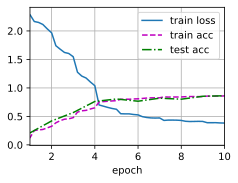

In [5]:
# 设置学习率lr为0.1，迭代次数num_epochs为10，批量大小batch_size为128。
lr, num_epochs, batch_size = 0.1, 10, 128
# 加载Fashion-MNIST数据集，并将其划分为训练集和测试集。训练集和测试集的批量大小都为batch_size，并将图像大小调整为224x224。
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
# 调用train_ch6函数来训练模型。该函数接受神经网络模型net，训练数据迭代器train_iter，
# 测试数据迭代器test_iter，迭代次数num_epochs，学习率lr，以及指定是否使用GPU进行训练。该函数会打印每个epoch的训练损失、训练准确率和测试准确率。
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* NiN使用由一个卷积层和多个$1\times 1$卷积层组成的块。该块可以在卷积神经网络中使用，以允许更多的每像素非线性。
* NiN去除了容易造成过拟合的全连接层，将它们替换为全局平均汇聚层（即在所有位置上进行求和）。该汇聚层通道数量为所需的输出数量（例如，Fashion-MNIST的输出为10）。
* 移除全连接层可减少过拟合，同时显著减少NiN的参数。
* NiN的设计影响了许多后续卷积神经网络的设计。

## 练习

1. 调整NiN的超参数，以提高分类准确性。
1. 为什么NiN块中有两个$1\times 1$卷积层？删除其中一个，然后观察和分析实验现象。
1. 计算NiN的资源使用情况。
    1. 参数的数量是多少？
    1. 计算量是多少？
    1. 训练期间需要多少显存？
    1. 预测期间需要多少显存？
1. 一次性直接将$384 \times 5 \times 5$的表示缩减为$10 \times 5 \times 5$的表示，会存在哪些问题？


[Discussions](https://discuss.d2l.ai/t/1869)
